In [1]:
from typing import AnyStr
import os
os.chdir("..")
os.chdir("src")
from data_cleaning import DataCleaning
os.chdir("..")
from transformers import pipeline
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
pd.set_option('display.max_colwidth', None)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# pipe = pipeline(
#     "zero-shot-classification",
#     model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",
#     framework="pt",
#     device=device,
#     batch_size=16,
# )


2024-04-11 17:36:07.664033: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 17:36:07.666295: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 17:36:07.693764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 17:36:08.207605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_cleaning_pipeline = DataCleaning()
df = data_cleaning_pipeline.run()

2024-04-11 17:36:09 - INFO - Data loaded!
2024-04-11 17:36:09 - INFO - Null values cleaned!
2024-04-11 17:36:09 - INFO - Data types asserted!
2024-04-11 17:36:09 - INFO - Full data cleaned!


In [3]:
df_trial = df.sample(10000)

In [79]:
zeroshot_topic_list = ["vehicles", "construction", "health/hospital", "education", "food"]

dataset = Dataset.from_pandas(df_trial[["DS_OBJETO"]])
output_total = pipe(dataset["DS_OBJETO"], zeroshot_topic_list, multi_label=False)
output_total = [output["labels"][0] for output in output_total]

df_trial["label"] = output_total

In [9]:
# df_trial["label"].value_counts()
# df_trial[["DS_OBJETO", "label"]].to_csv("output_llm_10000.csv", index=False)

construction       3242
education          2163
vehicles           1904
health/hospital    1776
food                915
Name: label, dtype: int64

In [35]:
pipe = pipeline(model="facebook/bart-large-mnli", device=device)

dataset = Dataset.from_pandas(df_trial[["DS_OBJETO"]])
output_total = pipe(dataset["DS_OBJETO"], zeroshot_topic_list, multi_label=False)
output_total = [output["labels"][0] for output in output_total]

In [12]:
df_trial = pd.read_csv("/home/bruno/mestrado-ufrgs/mestrado-ufrgs-cmp617-tce/models/llm/output_llm_10000.csv")

In [23]:
df_trial[df_trial["label"]=="education"][["DS_OBJETO", "label"]]

,DS_OBJETO,label
17810,Registro de Preços para contratação de empresa para realização de esterilização e inserção de microchip em animais domésticos (cães fêmeas).,education
113633,"PESQUISA DE PREÇO PARA LICITAÇÃO DE MATERIAL ELÉTRICO, CONFORME PROTOCOLO N° 3009/2021",education
33205,"Contratação de empresa para elaboração do PGR, PCMSO, LTCAT e LTIP.",education
24710,"CONTRATAÇÃO DE EMPRESA PARA FORNECIMENTO DE SOFTWARE DE GESTÃO PARA A SECRETARIA MUNICIPAL DE EDUCAÇÃO, CONFORME SOLICITAÇÃO DA COORDENADORIA DE TECNOLOGIA DE INFORMAÇÃO E COMUNICAÇÃO",education
101538,"CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA EXECUÇÃO DE PLANO DE PREVENÇÃO E PROTEÇÃO CONTRA INCENDIO (PPCI) NA EMEF CARLOS GOMES, LOCALIZADA EM VILA CASCATA, CONFORME PROJETOS EM ANEXO.",education
...,...,...
24178,"AQUISIÇÃO DE MERENDA ESCOLAR PARA AS ESCOLAS, E.M.E.I. SONHO MEU E PROJETO CONTRA TURNO ESCOLAR PARA O 2° SEMESTRE DE 2022.",education
59021,"Contratação de Empresa para a prestação de serviços de Transporte Escolar para alunos matriculados na Pré-Escola, da Educação Infantil, nas Séries Iniciais e Finais do Ensino Fundamental e no Ensino Médio, residentes no Município de Maratá.",education
27465,Aquisição de gêneros alimentícios para distribuição nas escolas da rede municipal de ensino,education
93694,Contratação de Prestação de Serviços de Transporte Escolar,education


In [27]:
# Nome do modelo que você está usando
model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"

# Criar o tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Criar o modelo
model = AutoModel.from_pretrained(model_name)


2024-04-05 22:59:12.626741: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 22:59:14.009266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 22:59:15.373602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [56]:
docs = df_trial["DS_OBJETO"].tolist()

# Tokenizar os documentos
tokenized_corpus = tokenizer(docs, padding=True, truncation=True, return_tensors="pt")

# Extrair os tokens
tokens_tensor = tokenized_corpus["input_ids"]

vec = []
for tokens in tokens_tensor:
    # Remover os zeros e converter os IDs para palavras usando o tokenizer
    tokens = [token for token in tokens.numpy().tolist() if token != 0]
    tokens_text = tokenizer.convert_ids_to_tokens(tokens)
    vec.append(tokens_text)

id2word = Dictionary(vec)

corpus = [id2word.doc2bow(text) for text in vec]

## talvez precise ajustar a qusetao dos tokens

In [72]:
vec

[['[CLS]',
  '▁Aqui',
  'sição',
  '▁de',
  '▁bloc',
  'os',
  '▁de',
  '▁pedr',
  'a',
  '▁gr',
  'ês',
  ',',
  '▁para',
  '▁rede',
  '▁de',
  '▁dren',
  'agem',
  '▁plu',
  'vial',
  '▁do',
  '▁Munic',
  'ípi',
  'o',
  '.',
  '[SEP]'],
 ['[CLS]',
  '▁Edit',
  'al',
  '▁de',
  '▁preg',
  'ão',
  '▁exclusiv',
  'o',
  '▁',
  'à',
  '▁participa',
  'ção',
  '▁de',
  '▁micro',
  'empresa',
  '▁',
  'e',
  '▁empresa',
  '▁de',
  '▁',
  'pequen',
  'o',
  '▁porte',
  '▁para',
  '▁presta',
  'ção',
  '▁de',
  '▁',
  's',
  'erviços',
  '▁de',
  '▁E',
  'labora',
  'ção',
  '▁de',
  '▁P',
  'PCI',
  '▁(',
  'Plan',
  'o',
  '▁de',
  '▁Preven',
  'ção',
  '▁',
  'e',
  '▁Prote',
  'ção',
  '▁Contra',
  '▁Inc',
  'ên',
  'dio',
  ').',
  '[SEP]'],
 ['[CLS]',
  '▁',
  'Registro',
  '▁de',
  '▁',
  'Preço',
  's',
  '▁para',
  '▁contrat',
  'ação',
  '▁de',
  '▁empresa',
  '▁para',
  '▁realiza',
  'ção',
  '▁de',
  '▁este',
  'ril',
  'ização',
  '▁',
  'e',
  '▁inser',
  'ção',
  '▁de',
  '▁m

In [70]:
coherence_model_lda = CoherenceModel(
    topics=df_trial["label"], texts=vec, dictionary=id2word, coherence="c_v", corpus=corpus
)
coherence_model_lda.get_coherence()

In [4]:
# precisa instalar o pytorch antes, pro meu caso foi o comando abaixo (mas no readme nao precisa passar o comando)
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

## Embedder + Kmeans

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

data_cleaning_pipeline = DataCleaning()
df = data_cleaning_pipeline.run()

corpus = df["DS_OBJETO"].values.tolist()

corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 7
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

np.mean(cosine_distances(corpus_embeddings, clustering_model.cluster_centers_))

## Top2Vec

In [3]:
# pip install top2vec

In [3]:
documents = df["DS_OBJETO"].values.tolist()

In [5]:
from top2vec import Top2Vec

model = Top2Vec(documents, embedding_model='universal-sentence-encoder-multilingual')

2024-04-11 17:39:29,170 - top2vec - INFO - Pre-processing documents for training
2024-04-11 17:39:29 - INFO - Pre-processing documents for training
/home/brunodifranco/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-04-11 17:39:33,753 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2024-04-11 17:39:33 - INFO - Downloading universal-sentence-encoder-multilingual model
2024-04-11 17:39:34,463 - top2vec - INFO - Creating joint document/word embedding
2024-04-11 17:39:34 - INFO - Creating joint document/word embedding
2024-04-11 17:41:22,883 - top2vec - INFO - Creating lower dimension embedding of documents
2024-04-11 17:41:22 - INFO - Creating lower dimension embedding of documents
/home/brunodifranco/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB ver

929

In [12]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())


In [22]:
import numpy as np

In [25]:
np.mean(word_scores[8])

0.13631941

In [18]:
word_scores

array([[0.10585205, 0.10070036, 0.09896142, ..., 0.03991222, 0.03976338,
        0.03966719],
       [0.12159492, 0.10832065, 0.10671639, ..., 0.0694648 , 0.06941008,
        0.06905147],
       [0.14631346, 0.13791847, 0.1359435 , ..., 0.04900376, 0.04887908,
        0.04883593],
       ...,
       [0.37425762, 0.36531144, 0.35307533, ..., 0.2327959 , 0.2318308 ,
        0.23065534],
       [0.11776892, 0.11470513, 0.11446144, ..., 0.08016691, 0.07924365,
        0.07878122],
       [0.27865106, 0.25847918, 0.25310016, ..., 0.18546492, 0.18523353,
        0.18438017]], dtype=float32)

In [10]:
len(topic_words)

77

0      1718
1      1472
2      1459
3      1419
4      1230
       ... 
924      18
925      17
926      17
927      16
928      14
Name: count, Length: 929, dtype: int64

In [46]:
cosine_scores = []

for index, num_docs in model.topic_sizes.items():
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=index, num_docs=num_docs)
    cosine_scores.append(np.mean(document_scores))

In [48]:
np.mean(cosine_scores)

0.72394246

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=AQUI É O INDEX, num_docs=AQUI E O VALOR)

In [40]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=928, num_docs=14)

In [41]:
np.mean(document_scores)

0.6120101

In [6]:

for doc, score, doc_id in zip(documents, document_scores, document_ids):



Document: 50845, Score: 0.9198291301727295
-----------
CONTRATAÇÃO DE EMPRESA PARA PRESTAÇÃO DE SERVIÇOS COM MÁQUINAS E CAMINHÕES, PARA MANUTENÇÃO DAS ESTRADAS DO MUNÍCIPIO DE ALEGRIA-RS
-----------

Document: 92292, Score: 0.9179564714431763
-----------
CONTRATAÇÃO DE EMPRESA ESPECIALIZADA NA PRESTAÇÃO DE SERVIÇOS DE INVENTÁRIO PATRIMONIAL, COM RECURSOS ADVINDOS DO BRDE E CONTRAPARTIDA DO MUNICÍPIO
-----------

Document: 7864, Score: 0.9156886339187622
-----------
CONTRATAÇÃO DE EMPRESA ESPECIALIZADA NA PRESTAÇÃO DE SERVIÇOS DE MANUTENÇÃO, SUPORTE E GERENCIAMENTO DOS EQUIPAMENTOS E DA INFRAESTRUTURA DE REDE DE TI
-----------

Document: 29520, Score: 0.914792537689209
-----------
CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA PRESTAÇÃO DE SERVIÇO DE REQUALIFICAÇÃO/MANUTENÇÃO DO PRÉDIO DA SECRETÁRIA MUNICIPAL DE PLANEJAMENTO, MEIO AMBIENTE E ABITAÇÃO
-----------

Document: 76367, Score: 0.9115080833435059
-----------
CONTRATAÇÃO DE EMPRESA PARA PRESTAÇÃO DE SERVIÇOS DE LIMPEZA E HIGIENIZAÇÃO

# VER COMO CALCULAR A SIMILIRIDADE DE COSSENO E TAMBEM COMO REDUZIR O NUMERO DE TOPICOS

In [5]:
model.get_num_topics()

959

In [6]:
new_topics = model.hierarchical_topic_reduction(num_topics=7)


In [13]:
new_topics

[[192,
  734,
  104,
  796,
  37,
  294,
  127,
  110,
  138,
  408,
  529,
  425,
  808,
  541,
  806,
  611,
  292,
  618,
  395,
  578,
  561,
  910,
  831,
  498,
  325,
  28,
  87,
  173,
  702,
  314,
  397,
  756,
  467,
  215,
  343,
  332,
  317,
  357,
  430,
  899,
  918,
  41,
  377,
  123,
  767,
  113,
  894,
  372,
  779,
  66,
  574,
  761,
  271,
  790,
  424,
  621,
  441,
  303,
  422,
  595,
  390,
  662,
  287,
  641,
  478,
  876,
  531,
  916,
  402,
  716,
  751,
  778,
  58,
  334,
  866,
  816,
  385,
  365,
  475,
  154,
  211,
  517,
  829,
  593,
  856,
  409,
  20,
  27,
  40,
  171,
  520,
  150,
  137,
  570,
  738,
  162,
  311,
  793,
  635,
  563,
  625,
  16,
  798,
  549,
  341,
  72,
  518,
  246,
  34,
  592,
  49,
  185,
  315,
  50,
  870,
  166,
  380,
  241,
  188,
  217,
  359,
  644,
  915,
  71,
  804,
  543,
  913,
  158,
  743,
  458,
  358,
  90,
  68,
  262,
  107,
  51,
  387,
  956,
  929,
  690,
  852,
  882,
  691,
  283,
  175,
  7

In [7]:
topic_words, word_scores, topic_nums = model.get_topics()

HI there, how are you doing?

I'm currently working on a project for my NLP class in my masters, and I just read your article regarding Top2Vec (https://medium.com/@janhavil1202/understanding-topic-modeling-with-top2vec-cdf58bcd6c09).

First of all I really liked your article, I think you made it easy to understand. I just have a question, do you happen to have the code you used to build the Top2Vec example? 

Specially the part right after you reduced the topics using hierarchical_topic_reduction. I'm trying to reduce my topics to about 7, and then plot these 7 word clouds, as well as the UMAP plot for the 7 topics. In addition, I'm trying to calculate the cosine similarity of the model (not sure if that's possible or if I can only get the cos sim of each topic). The reason behind this is I'm trying to compare the results to a LDA model (on which you can get the gensim Coherence score, and by using "c_v" method is the same as cosine similarity).

In [12]:
topic_nums

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [15]:
topic_words

array([['contratual', 'contratos', 'contratacao', 'contratante',
        'contrato', 'desta', 'contratada', 'especial', 'tais', 'estes',
        'previdenciario', 'especiais', 'contratados', 'contra', 'assim',
        'so', 'nesta', 'demais', 'destes', 'caps', 'contratado', 'duas',
        'privada', 'privadas', 'etc', 'somente', 'primeira', 'preco',
        'unica', 'pre', 'pesada', 'acima', 'setembro', 'pocos',
        'especializados', 'excepcionais', 'mun', 'privado', 'quanto',
        'pesadas', 'deste', 'porto', 'preventiva', 'brigada', 'este',
        'contratar', 'anos', 'acordo', 'especializadas',
        'especificacoes'],
       ['pocos', 'varias', 'duas', 'especificacoes', 'diversas', 'unica',
        'caps', 'unico', 'paraiso', 'previdenciario', 'especificacao',
        'primeira', 'anos', 'cinco', 'outras', 'quinze', 'numero',
        'preco', 'contratos', 'diversos', 'trinta', 'municipios',
        'requisitos', 'quatro', 'previsao', 'especificado', 'prefeito',
        '

In [ ]:
model.

In [11]:
new_topics

[[19,
  479,
  632,
  289,
  275,
  809,
  880,
  903,
  700,
  256,
  9,
  260,
  874,
  610,
  891,
  550,
  543,
  703,
  0,
  425,
  79,
  326,
  138,
  653,
  416,
  294,
  296,
  801,
  223,
  508,
  194,
  810,
  573,
  462,
  622,
  389,
  295,
  178,
  199,
  380,
  167,
  735,
  83,
  35,
  72,
  528,
  217,
  2,
  218,
  11,
  48,
  203,
  548,
  350,
  419,
  496,
  6],
 [111,
  12,
  399,
  404,
  501,
  303,
  344,
  330,
  242,
  821,
  764,
  745,
  692,
  718,
  871,
  345,
  106,
  724,
  530,
  514,
  281,
  913,
  667,
  522,
  480,
  563,
  338,
  285,
  82,
  185,
  38,
  824,
  511,
  395,
  267,
  551,
  16,
  741,
  459,
  458,
  24,
  702,
  449,
  143,
  86,
  757,
  120,
  754,
  655,
  119,
  152,
  21,
  354,
  466,
  301,
  325,
  321,
  523,
  851,
  8,
  299,
  157,
  211,
  297,
  588,
  557,
  843,
  4,
  693,
  409,
  128,
  661,
  269,
  47,
  405,
  675,
  316,
  618,
  237,
  343,
  447,
  453,
  644,
  80,
  274,
  531,
  725,
  270,
  854,
  286

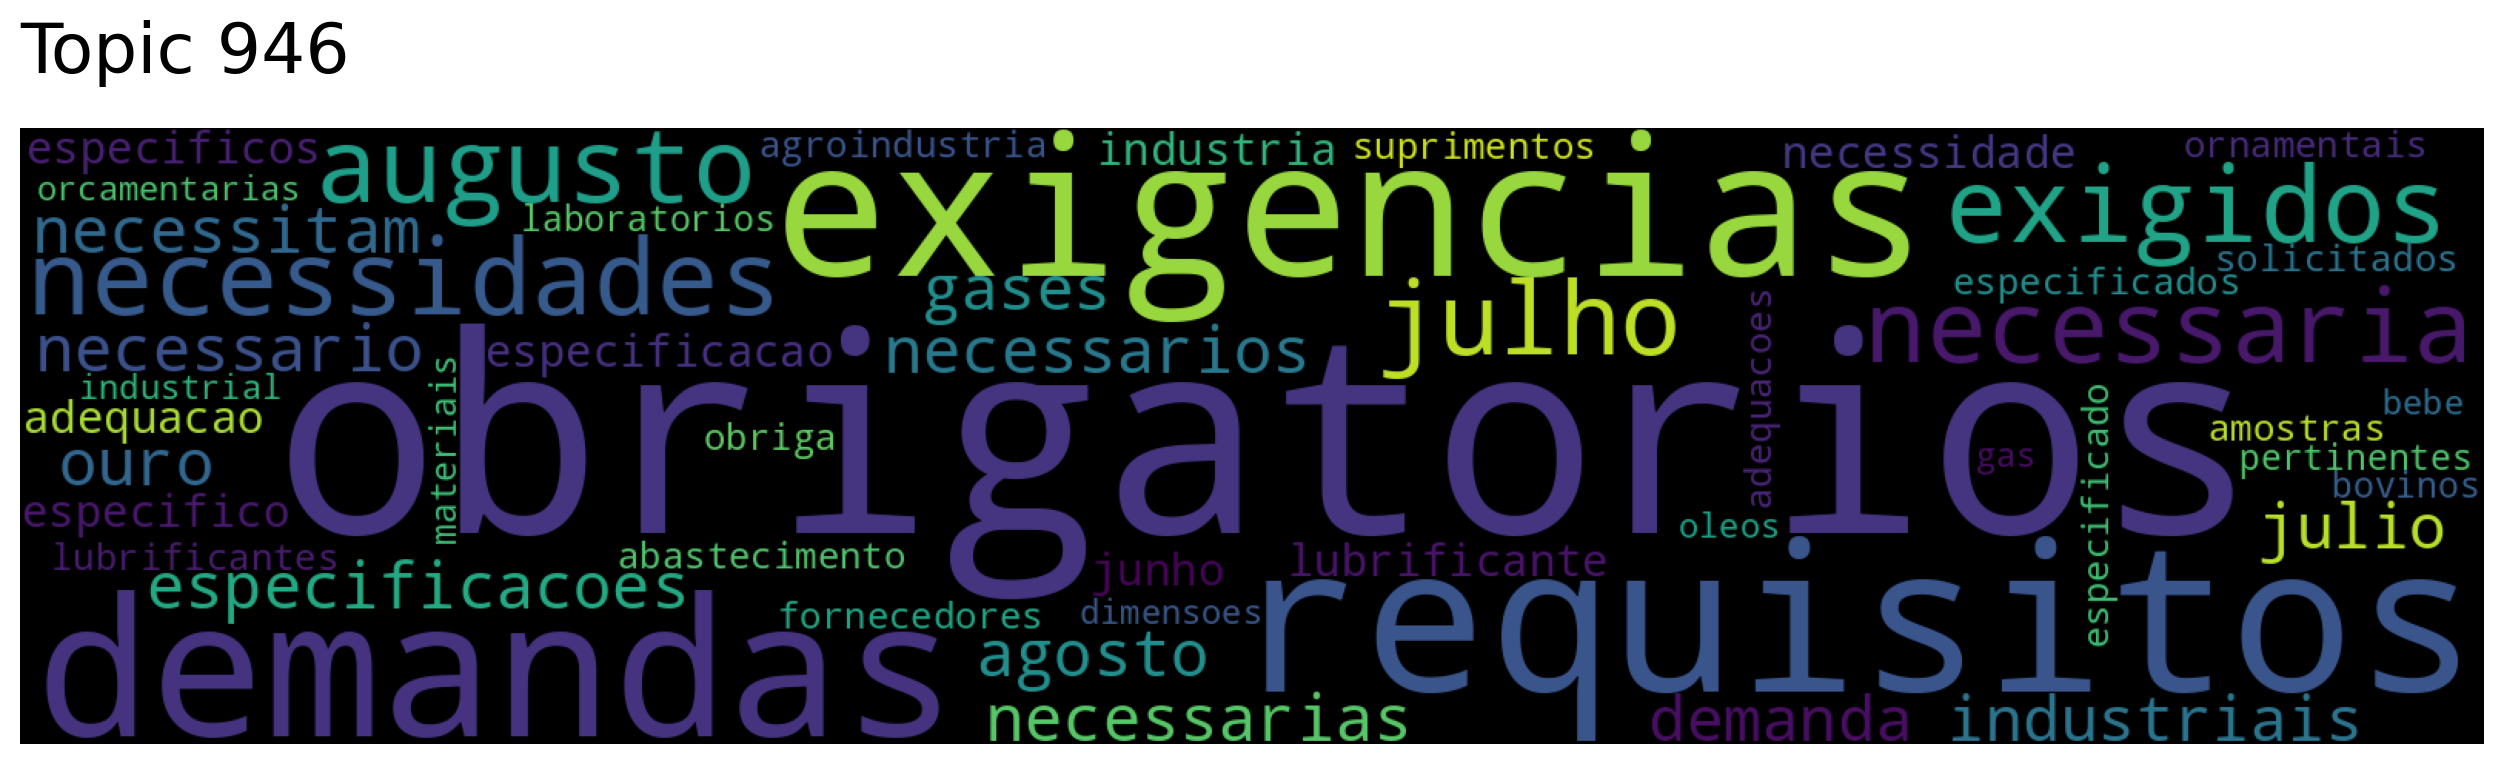

In [16]:
model.generate_topic_wordcloud(topic_num=946)

In [ ]:

>>> model.get_num_topics()
77
